Расмотрим пример на датасете из репозитория UCI

Описание данных - https://archive.ics.uci.edu/ml/datasets/banknote+authentication#

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("data_banknote_authentication.txt", header=None)
data.head(3)

,0,1,2,3,4
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


У нас есть 4 признака и 1 целевая переменная (бинарная) - нужно определить поддельная купюра или нет

In [2]:
print(data.shape)

(1372, 5)


Всего 1372 купюры

Посмотрим на соотношение классов

In [3]:
data.iloc[:, -1].value_counts()

0    762
1    610
Name: 4, dtype: int64

Разбиваем выборку на тренировочную и тестовую части и обучаем модель (в примере - градиентный бустинг)

In [4]:
from sklearn.model_selection import train_test_split

x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [5]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

[14:07:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dreamwall/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Проверяем качество

In [6]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    return f1, roc, rec, prc
    
evaluate_results(y_test, y_predict)

Classification results:
f1: 99.57%
roc: 99.57%
recall: 99.15%
precision: 100.00%


(0.9957081545064378, 0.9957264957264957, 0.9914529914529915, 1.0)

In [7]:
f1, roc, rec, prc = evaluate_results(y_test, y_predict)

Classification results:
f1: 99.57%
roc: 99.57%
recall: 99.15%
precision: 100.00%


In [8]:
f1

0.9957081545064378

### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [9]:
mod_data = data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 153/610 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [10]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    1219
 1     153
Name: class_test, dtype: int64


* We now have just 153 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

* Recall that col 4 still holds the actual label

In [11]:
mod_data.head(10)

,0,1,2,3,4,class_test
0,3.62160,8.6661,-2.80730,-0.44699,0,-1
1,4.54590,8.1674,-2.45860,-1.46210,0,-1
2,3.86600,-2.6383,1.92420,0.10645,0,-1
3,3.45660,9.5228,-4.01120,-3.59440,0,-1
4,0.32924,-4.4552,4.57180,-0.98880,0,-1
5,4.36840,9.6718,-3.96060,-3.16250,0,-1
6,3.59120,3.0129,0.72888,0.56421,0,-1
7,2.09220,-6.8100,8.46360,-0.60216,0,-1
8,3.20320,5.7588,-0.75345,-0.61251,0,-1
9,1.53560,9.1772,-2.27180,-0.73535,0,-1


Remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] is the original class label for positive and negative data [:-1] is the new class for positive and unlabeled data

In [12]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [13]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(153, 6) (153, 6)


In [14]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

[14:07:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification results:
f1: 95.63%
roc: 97.21%
recall: 99.49%
precision: 92.06%


/home/dreamwall/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


(0.9563106796116505,
 0.9721016131463892,
 0.9949494949494949,
 0.9205607476635514)

### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь:

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Dataset - https://www.kaggle.com/ronitf/heart-disease-uci

1. age
2. sex
3. cp - chest pain type (4 values)
4. trestbps - resting blood pressure
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl
7. restecg - resting electrocardiographic results (values 0,1,2)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal - 3 = normal; 6 = fixed defect; 7 = reversable defect

In [16]:
hdata = pd.read_csv('heart.csv')
hdata.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [17]:
hdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [18]:
hdata.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [19]:
# null check
hdata.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [20]:
feats = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_feats = ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']

##### Для начала обработаем не категорийные признаки

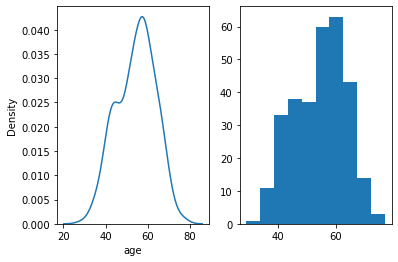

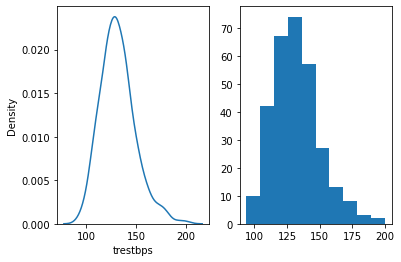

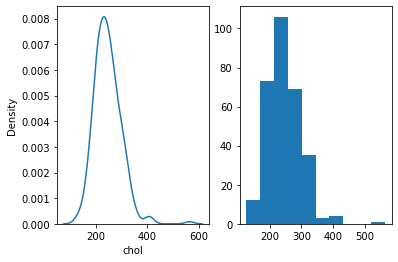

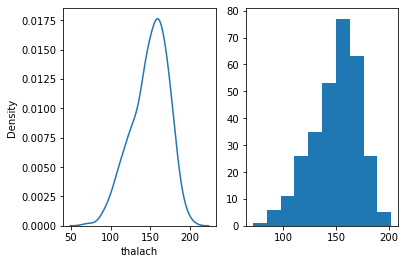

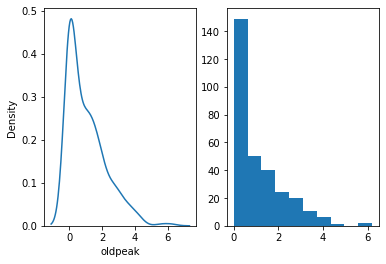

In [21]:
for name in feats:
  plt.subplot(1,2,1)
  sns.kdeplot(hdata[name])
  plt.subplot(1,2,2)
  plt.hist(hdata[name])
  plt.show()

#####  Обработаем колонки trestbps, thalach

In [22]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

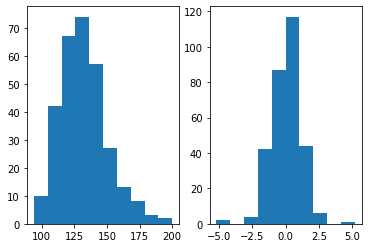

In [23]:
dq = qt.fit_transform(hdata['trestbps'].values.reshape(-1,1))
plt.subplot(1,2,1)
plt.hist(hdata['trestbps'])
plt.subplot(1,2,2)
plt.hist(dq)
plt.show()

In [24]:
hdata['trestbps'] = dq

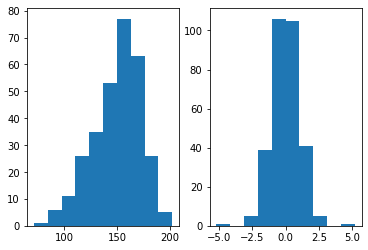

In [25]:
dq = qt.fit_transform(hdata['thalach'].values.reshape(-1,1))
plt.subplot(1,2,1)
plt.hist(hdata['thalach'])
plt.subplot(1,2,2)
plt.hist(dq)
plt.show()

In [26]:
hdata['thalach'] = dq

In [27]:
hdata.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,0.882543,233,1,0,-0.133194,0,2.3,0,0,1,1
1,37,1,2,0.012450,250,0,1,2.056492,0,3.5,0,0,2,1
2,41,0,1,0.012450,204,0,0,0.971849,0,1.4,2,0,2,1


##### Chol 

In [28]:
hdata['chol'].describe().T

count    303.000000
mean     246.264026
std       51.830751
min      126.000000
25%      211.000000
50%      240.000000
75%      274.500000
max      564.000000
Name: chol, dtype: float64

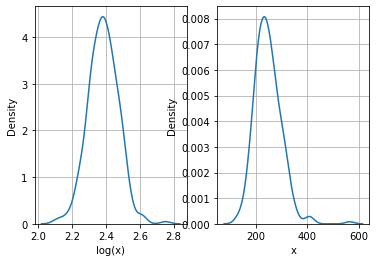

In [29]:
plt.subplot(1,2,1)
sns.kdeplot(np.log10(hdata['chol'].values+1))
plt.xlabel('log(x)')
plt.grid('On')
plt.subplot(1,2,2)
sns.kdeplot((hdata['chol'].values+1))
plt.xlabel('x')
plt.grid('On')
plt.show()

In [30]:
from scipy import stats

парамeтр для преобразования Бокса-Кокса:  -0.11075692218999027


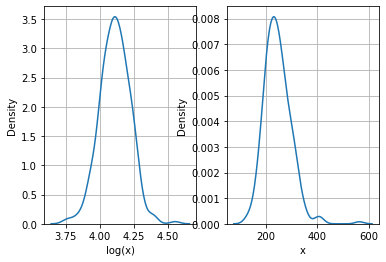

In [31]:
chol_new, lyamb = stats.boxcox(hdata['chol']+1)

print('парамeтр для преобразования Бокса-Кокса: ',lyamb)
plt.subplot(1,2,1)
sns.kdeplot(chol_new)
plt.xlabel('log(x)')
plt.grid('On')
plt.subplot(1,2,2)
sns.kdeplot((hdata['chol'].values))
plt.xlabel('x')
plt.grid('On')
plt.show()


In [32]:
hdata['chol'] = chol_new

In [33]:
hdata.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,0.882543,4.094521,1,0,-0.133194,0,2.3,0,0,1,1
1,37,1,2,0.012450,4.132699,0,1,2.056492,0,3.5,0,0,2,1
2,41,0,1,0.012450,4.021680,0,0,0.971849,0,1.4,2,0,2,1


##### Oldpeak

In [34]:
hdata['oldpeak'].describe().T

count    303.000000
mean       1.039604
std        1.161075
min        0.000000
25%        0.000000
50%        0.800000
75%        1.600000
max        6.200000
Name: oldpeak, dtype: float64

парамeтр для преобразования Бокса-Кокса:  -0.5024659604311568


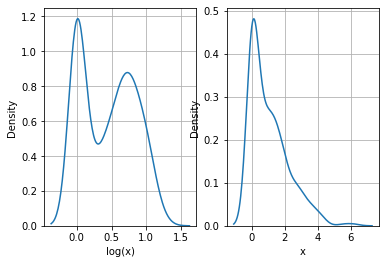

In [35]:
oldpeak_new, lyamb = stats.boxcox(hdata['oldpeak']+1)

print('парамeтр для преобразования Бокса-Кокса: ',lyamb)
plt.subplot(1,2,1)
sns.kdeplot(oldpeak_new)
plt.xlabel('log(x)')
plt.grid('On')
plt.subplot(1,2,2)
sns.kdeplot((hdata['oldpeak'].values))
plt.xlabel('x')
plt.grid('On')
plt.show()

In [36]:
hdata['oldpeak'] = oldpeak_new

In [37]:
hdata.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,0.882543,4.094521,1,0,-0.133194,0,0.897845,0,0,1,1
1,37,1,2,0.012450,4.132699,0,1,2.056492,0,1.055476,0,0,2,1
2,41,0,1,0.012450,4.021680,0,0,0.971849,0,0.708296,2,0,2,1
3,56,1,1,-0.648663,4.101478,0,1,1.344434,0,0.508937,2,0,2,1
4,57,0,0,-0.648663,4.317124,0,1,0.539700,1,0.418628,2,0,2,1


##### обучить любой классификатор (какой вам нравится)

In [38]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [39]:
X_train, X_test, y_train, y_test = train_test_split(hdata, hdata['target'], random_state=0)

In [40]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [41]:
sex = Pipeline([
                ('selector', FeatureSelector(column='sex')),
                ('ohe', OHEEncoder(key='sex'))
            ])
sex.fit(X_train)
sex.transform(X_test).head(3)

,sex_0,sex_1
225,0,1
152,0,1
228,0,1


In [42]:
final_transformers = list()

for cat_col in cat_feats:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in feats:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler(cont_col)) 
            ])
    final_transformers.append((cont_col, cont_transformer))

In [43]:
features = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', features)])

In [44]:
pipeline = Pipeline([
    ('features',features),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [45]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('sex',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='sex')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='sex'))])),
                                                ('cp',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='cp')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='cp'))])),
                                                ('restecg',
                                                 Pipeline(steps=[('selector',
                                        

In [46]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10392521, 0.92969183, 0.71471591, 0.0035242 , 0.02787858,
       0.35404912, 0.04451336, 0.01383976, 0.00637564, 0.00343597])

In [47]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.432016, F-Score=0.876, Precision=0.848, Recall=0.907


In [49]:
models_results = {
    'Model Name': [],
    'F-score': [],
    'Precision': [],
    'Recall': []
}

def res_update(res_dict, name, fscore, prec, rec):
    upd_list = [name, fscore, prec, rec]
    for upd in enumerate(upd_list):
        res_dict[list(models_results.keys())[upd[0]]].append(upd[1])
    return res_dict


res_update(models_results, 'GradientBoosting',
                           fscore[ix],
                           precision[ix],
                           recall[ix])

models_results

{'Model Name': ['GradientBoosting'],
 'F-score': [0.8764044943820224],
 'Precision': [0.8478260869565217],
 'Recall': [0.9069767441860465]}

##### далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [50]:
hhdata = hdata.copy()

##### выполним преобразование категорий вручную

In [51]:
for cat_col in cat_feats:
    enc = OHEEncoder(key=cat_col)
    enc.fit(hhdata[cat_col])
    hhdata = hhdata.join(enc.transform(hhdata[cat_col]))

In [52]:
hhdata.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,1,3,0.882543,4.094521,1,0,-0.133194,0,0.897845,...,0,1,0,0,0,0,0,1,0,0
1,37,1,2,0.012450,4.132699,0,1,2.056492,0,1.055476,...,0,1,0,0,0,0,0,0,1,0
2,41,0,1,0.012450,4.021680,0,0,0.971849,0,0.708296,...,1,1,0,0,0,0,0,0,1,0


##### Верну в конец датафрейма колонку таргет

In [53]:
target = hhdata.pop('target')

In [54]:
hhdata.insert(36, 'target', target)

In [55]:
hhdata.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,target
0,63,1,3,0.882543,4.094521,1,0,-0.133194,0,0.897845,...,1,0,0,0,0,0,1,0,0,1


##### Обернул в функцию для удобства

In [56]:
mod_data = hhdata.copy()
#get the indices of the positives samples
def ceil_changer(mod_data, c):
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
    #shuffle them
    np.random.shuffle(pos_ind)
    # leave just 25% of the positives marked
    pos_sample_len = int(np.ceil(c * len(pos_ind)))
    print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
    pos_sample = pos_ind[:pos_sample_len]

    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    print('target variable:\n', mod_data.iloc[:,-1].value_counts())

    x_data = mod_data.iloc[:,:-2].values # just the X 
    y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
    y_positive = mod_data.iloc[:,-2].values # original class

    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    print(neg_sample.shape, pos_sample.shape)
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

    model = GradientBoostingClassifier()

    model.fit(sample_train.iloc[:,:-2].values, 
              sample_train.iloc[:,-2].values)
    y_predict = model.predict(sample_test.iloc[:,:-2].values)
    f1, roc, rec, prc = evaluate_results(sample_test.iloc[:,-2].values, y_predict)
    return f1, roc, rec, prc

##### Циклом проверим все варианты

In [58]:
c_values = np.linspace(0.1, 0.9, 15)

for c in c_values:
    try:
        f1, roc, rec, prc = ceil_changer(mod_data, c)
    except ValueError:
        print(f'{c} не верно делит дф') # при некоторых значениях остаются только положительные 
        
    else:
        res_update(models_results, f'C_%s' %c,
                                   f1,
                                   prc,
                                   rec)

models_results

Using 17/165 as positives and unlabeling the rest
target variable:
 -1    286
 1     17
Name: class_test, dtype: int64
(17, 38) (17, 38)
Classification results:
f1: 72.38%
roc: 66.99%
recall: 80.85%
precision: 65.52%
Using 3/17 as positives and unlabeling the rest
target variable:
 -1    300
 1      3
Name: class_test, dtype: int64
(3, 38) (3, 38)
0.15714285714285714 не верно делит дф
Using 1/3 as positives and unlabeling the rest
target variable:
 -1    302
 1      1
Name: class_test, dtype: int64
(1, 38) (1, 38)
Classification results:
f1: 74.37%
roc: 68.71%
recall: 80.49%
precision: 69.11%
Using 1/1 as positives and unlabeling the rest
target variable:
 -1    302
 1      1
Name: class_test, dtype: int64
(1, 38) (1, 38)
Classification results:
f1: 76.42%
roc: 73.33%
recall: 78.05%
precision: 74.85%
Using 1/1 as positives and unlabeling the rest
target variable:
 -1    302
 1      1
Name: class_test, dtype: int64
(1, 38) (1, 38)
0.3285714285714286 не верно делит дф
Using 1/1 as positi

{'Model Name': ['GradientBoosting',
  'C_0.1',
  'C_0.2142857142857143',
  'C_0.27142857142857146',
  'C_0.5571428571428572',
  'C_0.6142857142857143',
  'C_0.6714285714285715',
  'C_0.7857142857142857',
  'C_0.9'],
 'F-score': [0.8764044943820224,
  0.7238095238095238,
  0.743661971830986,
  0.764179104477612,
  0.5413105413105412,
  0.6144578313253012,
  0.7055393586005831,
  0.7252747252747254,
  0.7700831024930749],
 'Precision': [0.8478260869565217,
  0.6551724137931034,
  0.6910994764397905,
  0.7485380116959064,
  0.5080213903743316,
  0.6071428571428571,
  0.6759776536312849,
  0.66,
  0.7055837563451777],
 'Recall': [0.9069767441860465,
  0.8085106382978723,
  0.8048780487804879,
  0.7804878048780488,
  0.5792682926829268,
  0.6219512195121951,
  0.7378048780487805,
  0.8048780487804879,
  0.8475609756097561]}

In [59]:
models_results = pd.DataFrame(models_results)

In [60]:
models_results

,Model Name,F-score,Precision,Recall
0,GradientBoosting,0.876404,0.847826,0.906977
1,C_0.1,0.723810,0.655172,0.808511
2,C_0.2142857142857143,0.743662,0.691099,0.804878
3,C_0.27142857142857146,0.764179,0.748538,0.780488
4,C_0.5571428571428572,0.541311,0.508021,0.579268
5,C_0.6142857142857143,0.614458,0.607143,0.621951
6,C_0.6714285714285715,0.705539,0.675978,0.737805
7,C_0.7857142857142857,0.725275,0.660000,0.804878
8,C_0.9,0.770083,0.705584,0.847561


<Figure size 432x288 with 0 Axes>

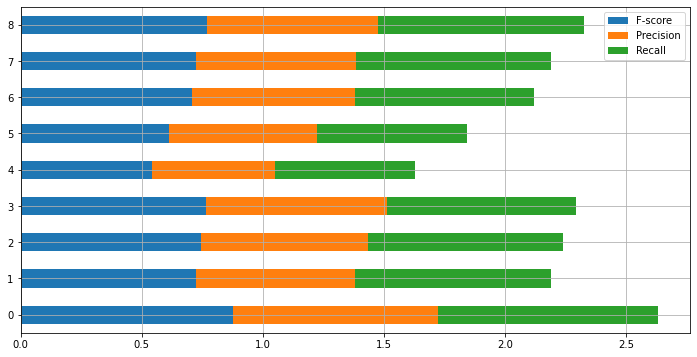

In [75]:
plt.figure()
models_results.plot.barh(stacked=True, figsize=(12, 6))
plt.grid()
plt.show()

##### Вывод:
Результаты random negative sampling хуже, чем результаты классификатора. 
Так же при изменении значения c (доли P в выборке), видно, что есть просадка на с=0.55, а далее опять возрастание результатов.